# Jonathan Halverson
# Wednesday, April 6, 2016
# Heigh-Weight-Gender: Gridsearch for optimal hyperparameters and evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

Here we create a classifier for gender based on height and weight data.

In [2]:
df = pd.read_csv('01_heights_weights_genders.csv')
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [3]:
df.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


The correlation between height and weight is

In [4]:
df.corr()

,Height,Weight
Height,1.000000,0.924756
Weight,0.924756,1.000000


In [5]:
male = df[df['Gender'] == 'Male']
female = df[df['Gender'] == 'Female']

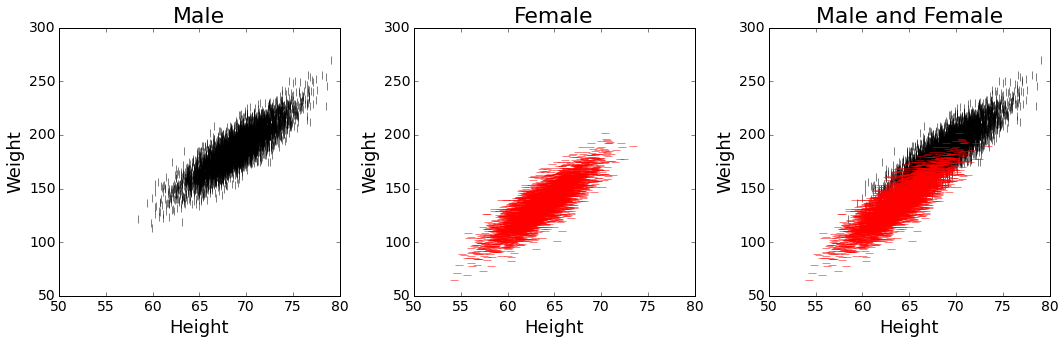

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax0.plot(male['Height'], male['Weight'], 'k|')
ax1.plot(female['Height'], female['Weight'], 'r_')
ax2.plot(male['Height'], male['Weight'], 'k|')
ax2.plot(female['Height'], female['Weight'], 'r_')
for ax in fig.get_axes():
    ax.set_xlabel("Height")
    ax.set_ylabel("Weight")
    ax.set_xlim(50, 80)
    ax.set_ylim(50, 300)
ax0.set_title('Male')
ax1.set_title('Female')
ax2.set_title('Male and Female')
plt.tight_layout()

The plots above show that there is a region where the two data sets overlap. Therefore we do not expect to get a perfectly clean separation.

To build a classifier in scikit-learn all inputs must be numerical:

In [7]:
X = df[['Height', 'Weight']]
y = df['Gender'].apply(lambda u: 0 if u == 'Male' else 1)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

k_range = range(1, 101)
param_grid = dict(n_neighbors=k_range, weights=['uniform', 'distance'])

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)
print grid.best_score_
print grid.best_params_

0.9188
{'n_neighbors': 64, 'weights': 'uniform'}


Below we plot accuracy scores for the range of k neighbors and the two different weightings:

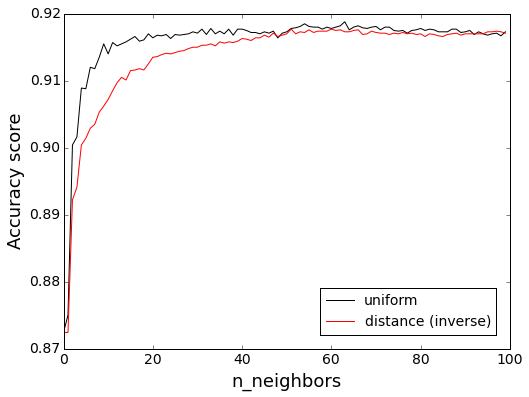

In [9]:
scores_uniform = [g[1] for g in grid.grid_scores_ if g[0]['weights'] == 'uniform']
scores_distance = [g[1] for g in grid.grid_scores_ if g[0]['weights'] == 'distance']
plt.plot(scores_uniform, 'k-', label='uniform')
plt.plot(scores_distance, 'r-', label='distance (inverse)')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy score')
plt.legend(loc='lower right')

The uniform weighting procedure from k is 30 through 100 gives approximately the same value. The optimal value of k was found to be 64.

/Library/Python/2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


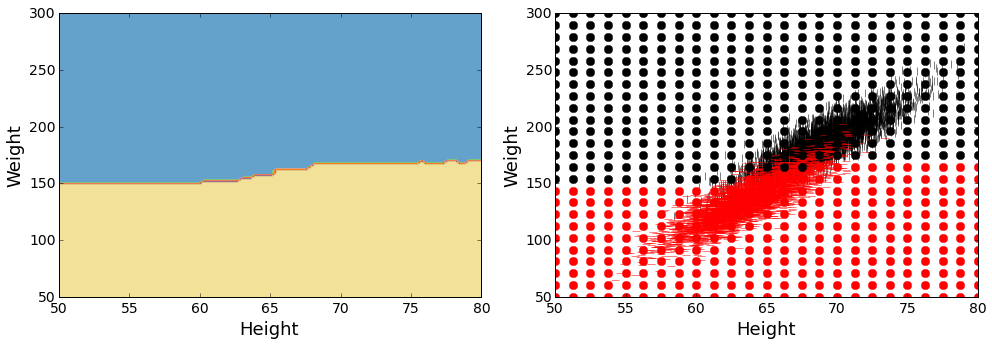

In [10]:
knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], weights=grid.best_params_['weights'])
knn.fit(X, y)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# decision boundary plot
x_min, x_max = 50, 80
y_min, y_max = 50, 300
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=100), np.linspace(y_min, y_max, num=100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)
ax0.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
ax0.set_xlabel("Height")
ax0.set_ylabel("Weight")

# original data
xyz = [(h, w, knn.predict((h, w))[0]) for h in np.linspace(50, 80, num=25) for w in np.linspace(50, 300, num=25)]
x_male = [h for h, w, p in xyz if p == 0]
y_male = [w for h, w, p in xyz if p == 0]
x_female = [h for h, w, p in xyz if p == 1]
y_female = [w for h, w, p in xyz if p == 1]
ax1.plot(male['Height'], male['Weight'], 'k|')
ax1.plot(female['Height'], female['Weight'], 'r_')
ax1.plot(x_male, y_male, 'ko')
ax1.plot(x_female, y_female, 'ro', mec='r')
ax1.set_xlabel("Height")
ax1.set_ylabel("Weight")
plt.tight_layout()

Let's compare knn with logistic regression first by cross validation then find hyperparameters.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print scores.mean()

0.9194


The cross validation score for logistic regression is slightly less than that of KNeighborsClassifier. Let's proceed with the analysis:

In [12]:
logreg.fit(X, y)
alpha = logreg.intercept_[0]
beta0, beta1 = logreg.coef_[0]

The dividing line for a threshold of 1/2 is given by $\beta_0 \textrm{height} + \beta_1 \textrm{weight} + \alpha=0$.

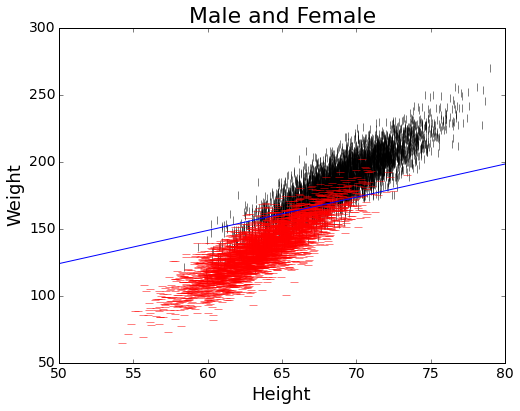

In [13]:
plt.plot(male['Height'], male['Weight'], 'k|')
plt.plot(female['Height'], female['Weight'], 'r_')
h = np.linspace(50, 80)
plt.plot(h, -(alpha + beta0) * h / beta1, 'b-')
plt.xlabel("Height")
plt.ylabel("Weight")
plt.xlim(50, 80)
plt.ylim(50, 300)
plt.title('Male and Female')

The blue line indicates the decision boundary between the two classes as determined by logistic regression. Note that logistic regression gives a separating line while kNN gives a non-linear boundary. We will encounter this again with kernal methods.

### Evaluation of the classifer

In [14]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)

In [15]:
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.9348


The null accuracy is the accuracy if one had predicted the most common class outcome for all observations. For the current set the null accuracy is around 50%.

In [16]:
y_test.value_counts()

0    1258
1    1242
Name: Gender, dtype: int64

In [17]:
print 'True:      ', y_test.values[0:20]
print 'Predicted: ', y_pred_class[0:20]

True:       [0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0]
Predicted:  [0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0]


In [18]:
# rows give actual, columns give predicted
print metrics.confusion_matrix(y_test, y_pred_class)

[[1170   88]
 [  75 1167]]


Confusion matrix because it tells whether the model is confusing the classes.

In [19]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
tp = confusion[1, 1]
tn = confusion[0, 0]
fp = confusion[0, 1]
fn = confusion[1, 0]

In [20]:
# correct predictions divided by total predictions
accuracy = (tp + tn) / float(tp + tn + fp + fn)
print accuracy, metrics.accuracy_score(y_test, y_pred_class)

0.9348 0.9348


In [21]:
# incorrect predictions divided by total predictions
classification_error = (fp + fn) / float(tp + tn + fp + fn)
print classification_error, 1.0 - accuracy

0.0652 0.0652


In [22]:
# sensitivity (or recall or true positive rate): when the actual value is positive, how often is the prediction correct
sensitivity = tp / float(tp + fn)
print sensitivity, metrics.recall_score(y_test, y_pred_class)

0.93961352657 0.93961352657


In [23]:
# the proportion of actual negative cases which are correctly identified
specificity = tn / float(tn + fp)
print specificity

0.930047694754


In [24]:
# (false positive rate) when the actual value is negative, how often is the prediction incorrect
false_positive_rate = fp / float(fp + tn)
print false_positive_rate

0.0699523052464


In [25]:
# accuracy of positive predictions
precision = tp / float(tp + fp)
print precision, metrics.precision_score(y_test, y_pred_class)

0.929880478088 0.929880478088


### Construct ROC curve

In [26]:
# store the predicted probabilities for class 1 
y_pred_prob = logreg.predict_proba(X_test)[:,1]

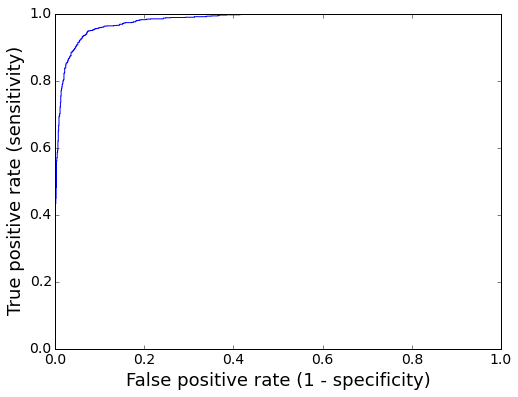

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')

In [28]:
print metrics.roc_auc_score(y_test, y_pred_prob)

0.981219710759


In [29]:
threshold = 0.85
print 'sensitivity =', tpr[thresholds > threshold][-1]
print 'specificity =', 1.0 - fpr[thresholds > threshold][-1]

sensitivity = 0.768921095008
specificity = 0.985691573927


We can run a cross validation using the area of the curve as the score:

In [30]:
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.97326239999999997